# 1. Dowload essential package and import libraries

In [1]:
!pip install -q yfinance

In [2]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Functions

### Performance metrics

In [3]:
# ROOT MEAN SQUARED PERCENTAGE ERROR
def RMSPE(y_true, y_pred):
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [4]:
# ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [5]:
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

### RV calculation

In [6]:
def realized_volatility_daily(series_log_return):
  n = len(series_log_return)
  return np.sqrt(np.sum(series_log_return ** 2) / (n-1))

### Creat sequence data for LSTM models

In [7]:
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        x = x_series[start_idx:end_idx].values
        y = y_series[end_idx]
        dataX.append(x)
        dataY.append(y)

    return np.array(dataX), np.array(dataY)

### Function for generate prediction for data

In [8]:
def forecast(model, range_idx):
    start_idx = input_df.index.get_loc(range_idx[0]) - (n_past-1)
    end_idx = input_df.index.get_loc(range_idx[-1])
    mat_X, _ = windowed_dataset(df.vol_current.iloc[start_idx:end_idx+1], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [9]:
def forecast_multi(model, range_idx):
    start_idx = input_df.index.get_loc(range_idx[0]) - (n_past-1)
    end_idx = input_df.index.get_loc(range_idx[-1])
    mat_X, _ = windowed_dataset(input_df.iloc[start_idx:end_idx+1], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### Metrics to judge performance of model

In [10]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

### Functions for visualization

In [11]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show()

In [12]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [13]:
def viz_test(y_true, y_pred):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_test, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title('Forecasting on Test Data')
        plt.legend(loc='best', frameon=True)

# Data collection & preprocessing

In [14]:
!mkdir /kaggle/working/images
directory_to_img = '/kaggle/working/images'

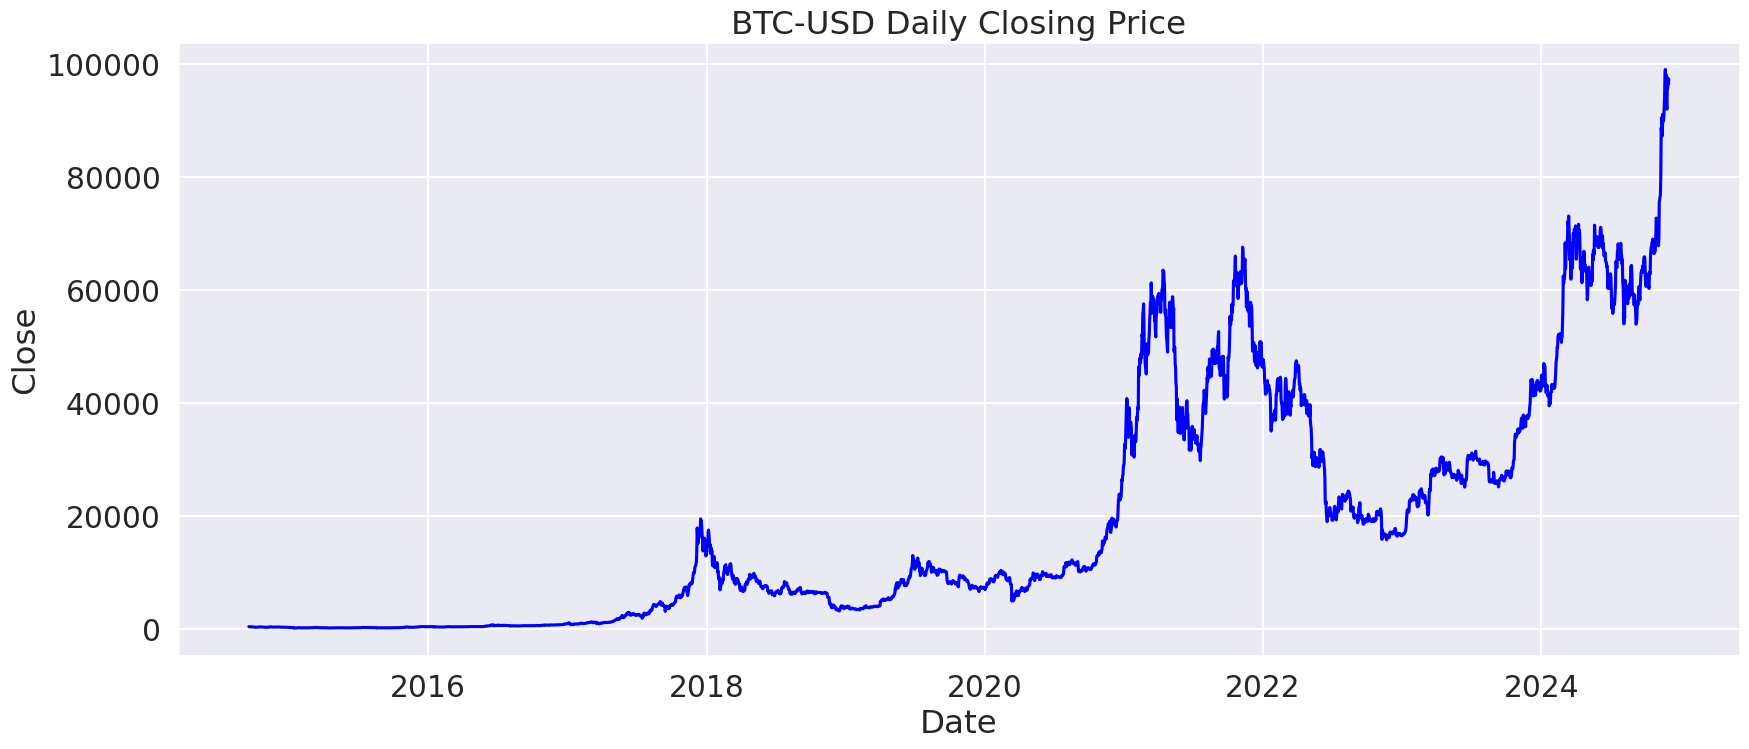

In [15]:
tckr = 'BTC-USD'
btc = yf.Ticker(tckr)
df = btc.history(period='max')

# PLOTTING
sns.set_context("talk", font_scale=1.3)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    
plt.tight_layout()
plt.savefig(os.path.join(directory_to_img, 'close.png'), 
            dpi=300, bbox_inches='tight');

In [16]:
INTERVAL_WINDOW = 30
n_future = 7

df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df['returns'] = 100 * df.Close.pct_change().dropna()
df['log_returns'] = np.log(df.Close / df.Close.shift(1))

df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW).apply(realized_volatility_daily)
df['vol_future'] = df.log_returns.shift(-n_future).rolling(window=INTERVAL_WINDOW).apply(realized_volatility_daily)

df.dropna(inplace=True)

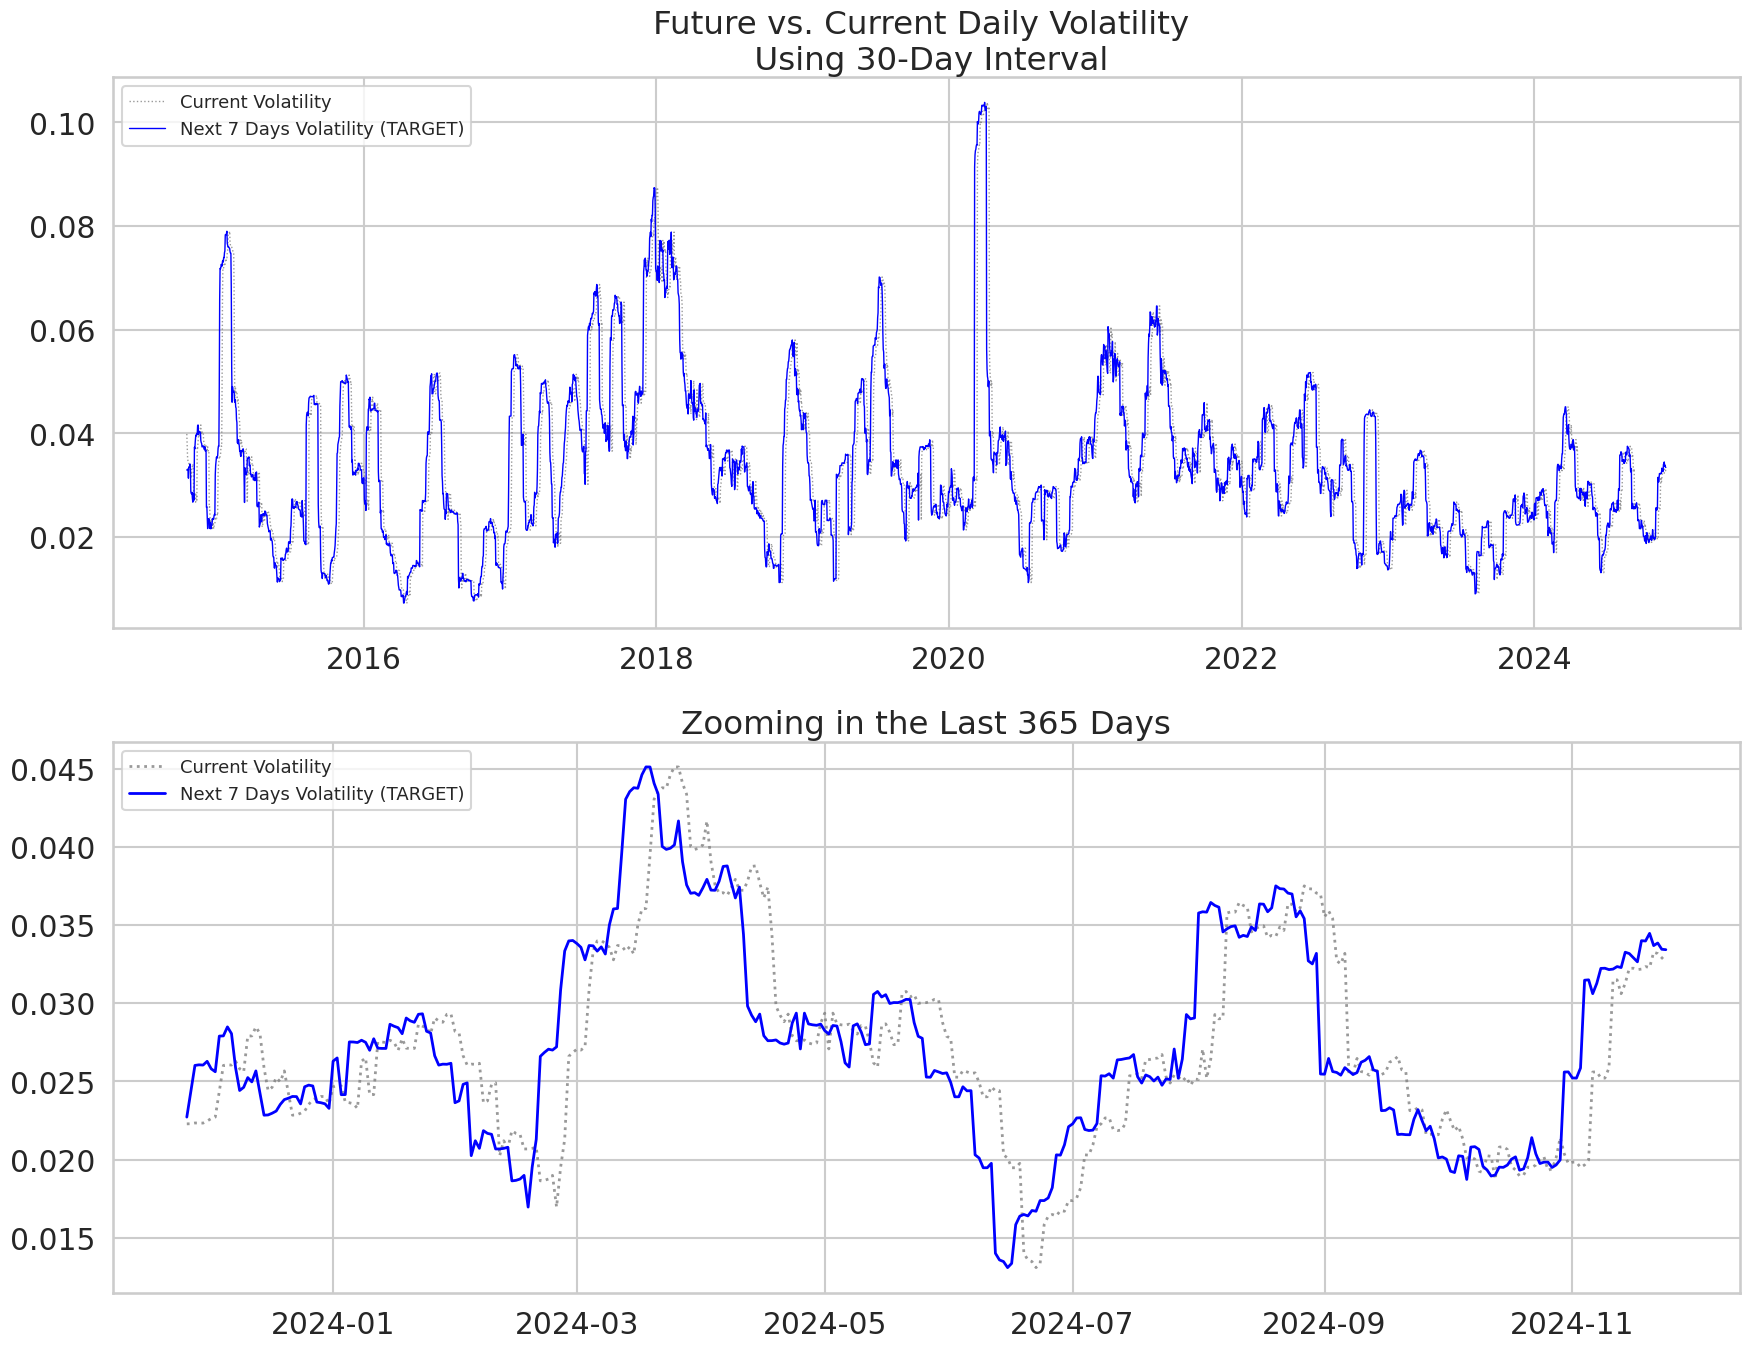

In [17]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'daily_vol.jpg'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [18]:
test_size = 30 * 3
val_size = 365 * 2

split_point_1 = len(df) - (val_size + test_size)
split_point_2 = len(df) - test_size

train_idx = df.index[:split_point_1]
val_idx = df.index[split_point_1:split_point_2]
test_idx = df.index[split_point_2:]

#Split target
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

# Split realized volatility (input)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

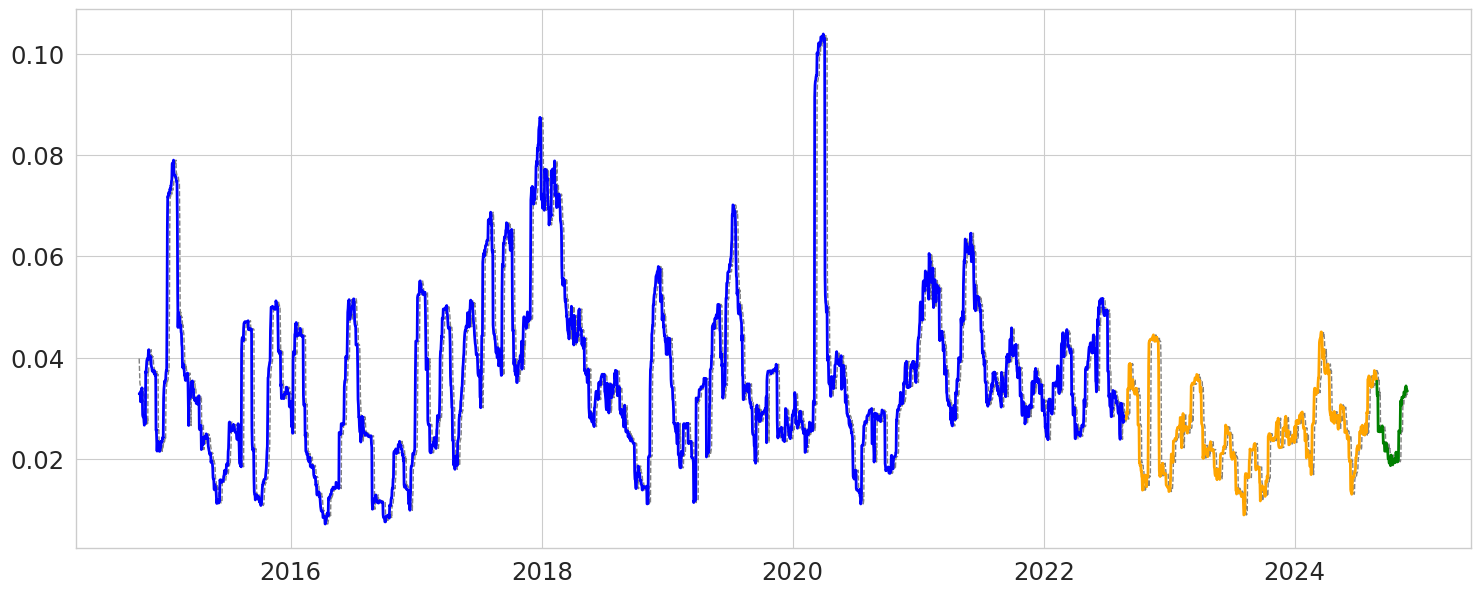

In [19]:
sns.set_context("paper", font_scale=2)
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,7))

    ax.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax.plot(y_test, color='green', label='Original Test Target', lw=2)

    plt.savefig(os.path.join(directory_to_img, 'train_val_test.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [20]:
df['HL_spread'] = (df.High - df.Low)/df.Close
df['CO_spread'] = (df.Close - df.Open)/df.Close

df.dropna(inplace=True)

In [21]:
features = ['HL_spread', 'CO_spread', 'Volume', 'vol_current']

input_df = df[features]
# input_df['vol_current'] = scale(scaler_vol, input_df.vol_current)
X_train = input_df.loc[train_idx]
X_val = input_df.loc[val_idx]

In [22]:
X_train.head()

,HL_spread,CO_spread,Volume,vol_current
Date,,,,
2014-10-17 00:00:00+00:00,0.026290,0.002611,13600700,0.039872
2014-10-18 00:00:00+00:00,0.041352,0.019073,11416800,0.037566
2014-10-19 00:00:00+00:00,0.019207,-0.004385,5914570,0.035089
2014-10-20 00:00:00+00:00,0.030905,-0.016680,16419000,0.034629
2014-10-21 00:00:00+00:00,0.030563,0.010490,14188900,0.034362


# LSTM models

### Univariate 1-Layered (20 units) LSTM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None


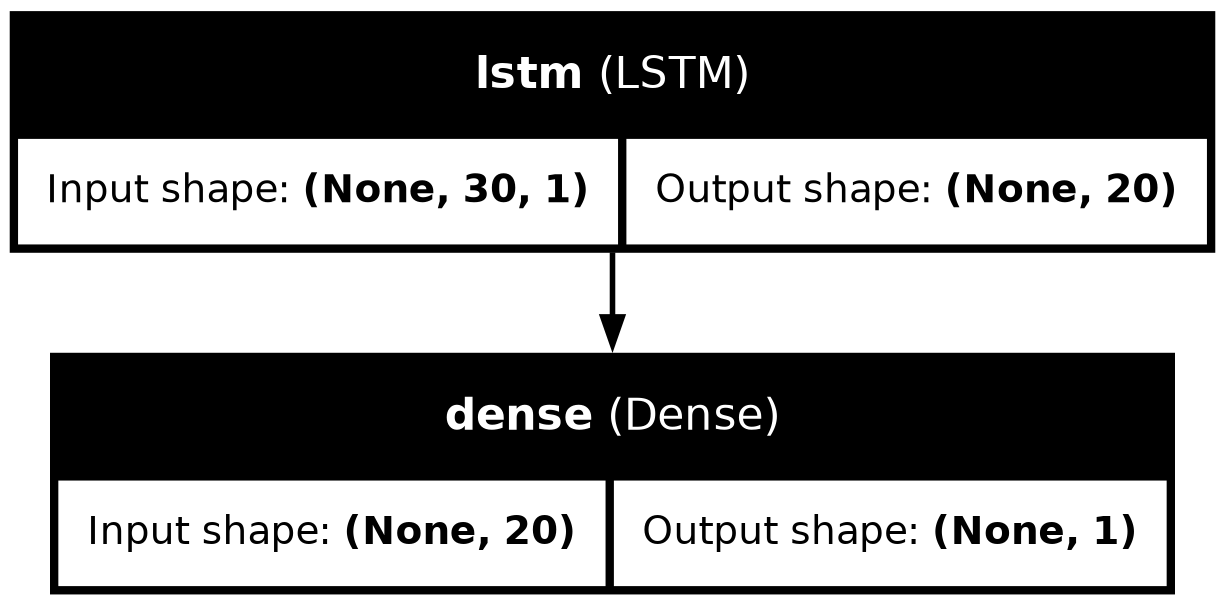

In [23]:
tf.keras.backend.clear_session()

np.random.seed(2024)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_1 = tf.keras.models.Sequential([
    InputLayer(input_shape=(n_past, 1)),                
    LSTM(20),
    Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe', 
                                  mode='min')

print(lstm_1.summary())
plot_model(lstm_1, to_file=os.path.join(directory_to_img, 'lstm_1_model.png'), show_layer_names=True, show_shapes=True)

In [24]:
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=[mat_X_val, mat_y_val], shuffle=True, 
                        verbose=0, batch_size=batch_size, epochs=200)

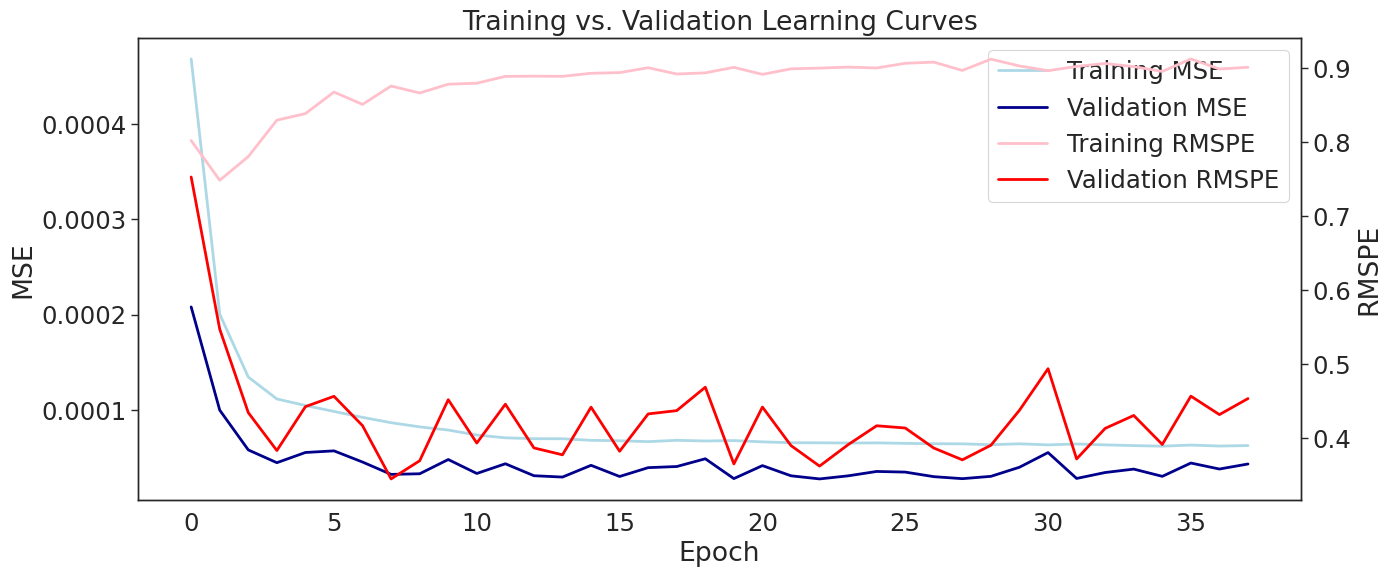

<Figure size 640x480 with 0 Axes>

In [25]:
viz_train_val_metrics(lstm_1_res)
plt.savefig(os.path.join(directory_to_img, 'error_1.png'), dpi=300, bbox_inches='tight')

In [26]:
lstm_1_preds = forecast(lstm_1, val_idx)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


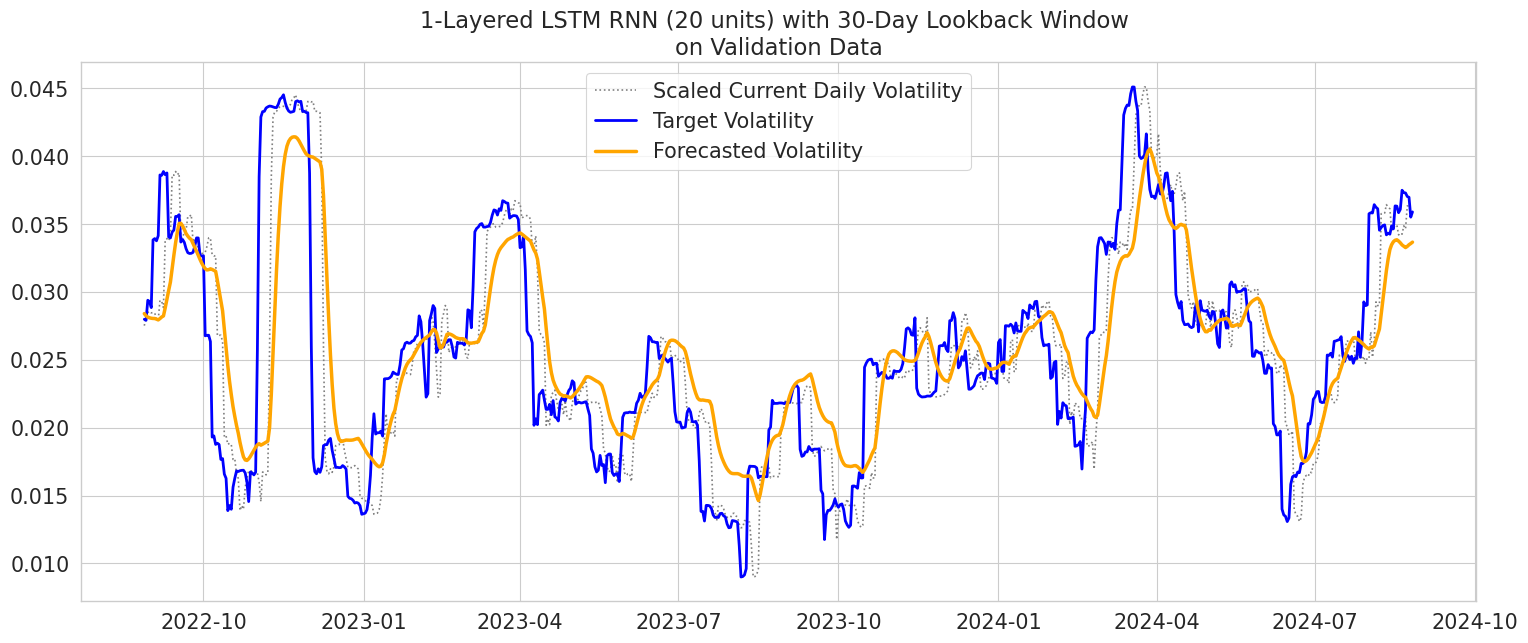

In [27]:
viz_model(y_val, lstm_1_preds, f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_1_val.png'), dpi=300, bbox_inches='tight')

In [28]:
log_perf(y_val, lstm_1_preds, f"LSTM 1 layer 20 units, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,"LSTM 1 layer 20 units, n_past=30",0.26317,0.005638


### Univariate 2-Layered Bidirectional (32/16 units) LSTM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

None


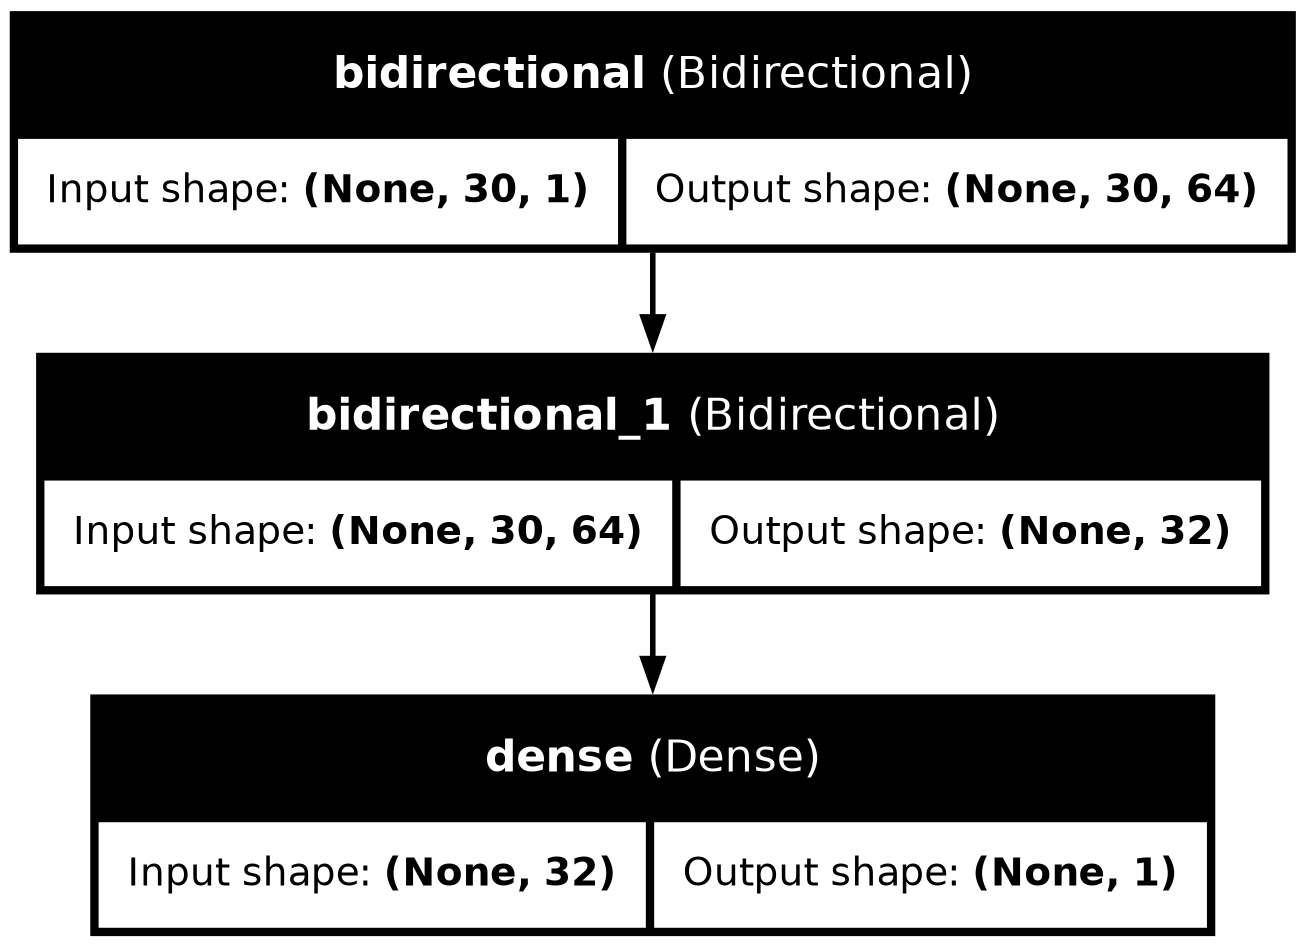

In [29]:
tf.keras.backend.clear_session()

np.random.seed(2024)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_2 = tf.keras.models.Sequential([
    InputLayer(input_shape=(n_past, 1)),                            

    Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    Bidirectional(tf.keras.layers.LSTM(16)),

    Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe', 
                                  mode='min')

print(lstm_2.summary())
plot_model(lstm_2, to_file=os.path.join(directory_to_img, 'lstm_2_model.png'), show_layer_names=True, show_shapes=True)

In [30]:
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=[mat_X_val, mat_y_val], shuffle=True, 
                        verbose=0, batch_size=batch_size, epochs=200)

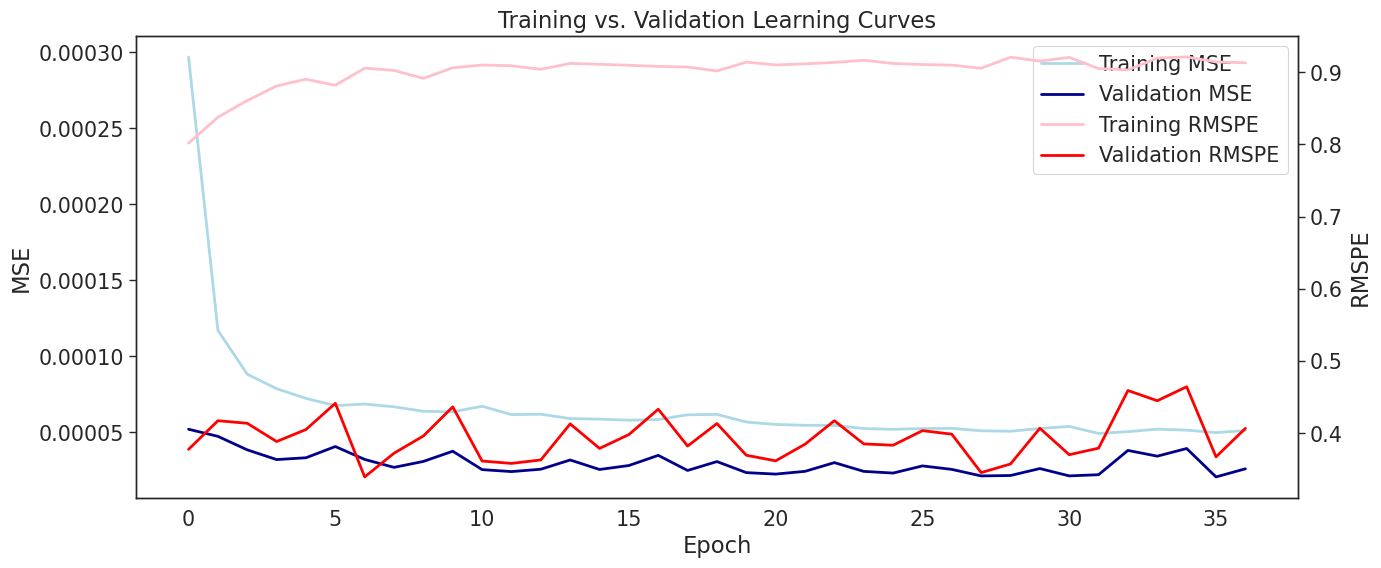

<Figure size 640x480 with 0 Axes>

In [31]:
viz_train_val_metrics(lstm_2_res)
plt.savefig(os.path.join(directory_to_img, 'error_2.png'), dpi=300, bbox_inches='tight')

In [32]:
lstm_2_preds = forecast(lstm_2, val_idx)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


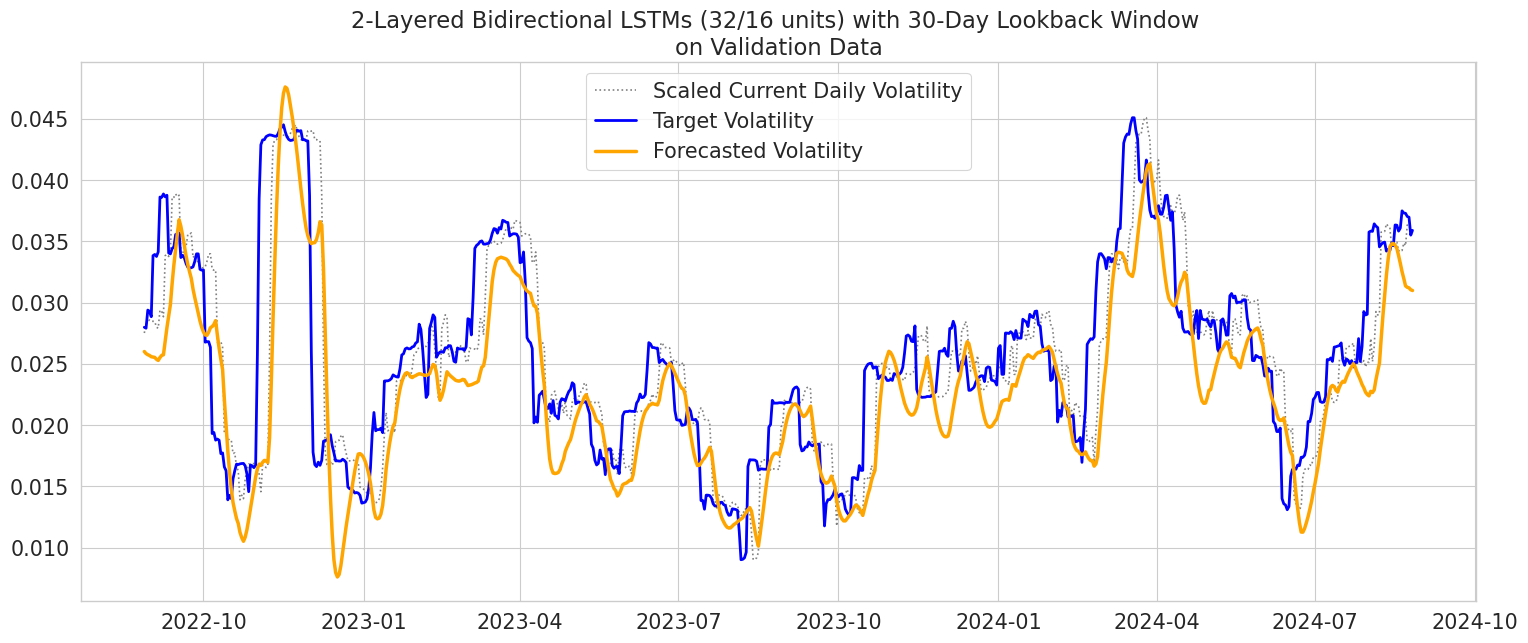

In [33]:
viz_model(y_val, lstm_2_preds, f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_2_val.png'), dpi=300, bbox_inches='tight')

In [34]:
log_perf(y_val, lstm_2_preds, f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,"LSTM 1 layer 20 units, n_past=30",0.263170,0.005638
1,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.224773,0.005690


### Multivariate 2-Layered Bidirectional (32/16 units) LSTM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 30, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,889 (77.69 KB)

 Trainable params: 19,881 (77.66 KB)

 Non-trainable params: 8 (32.00 B)

None


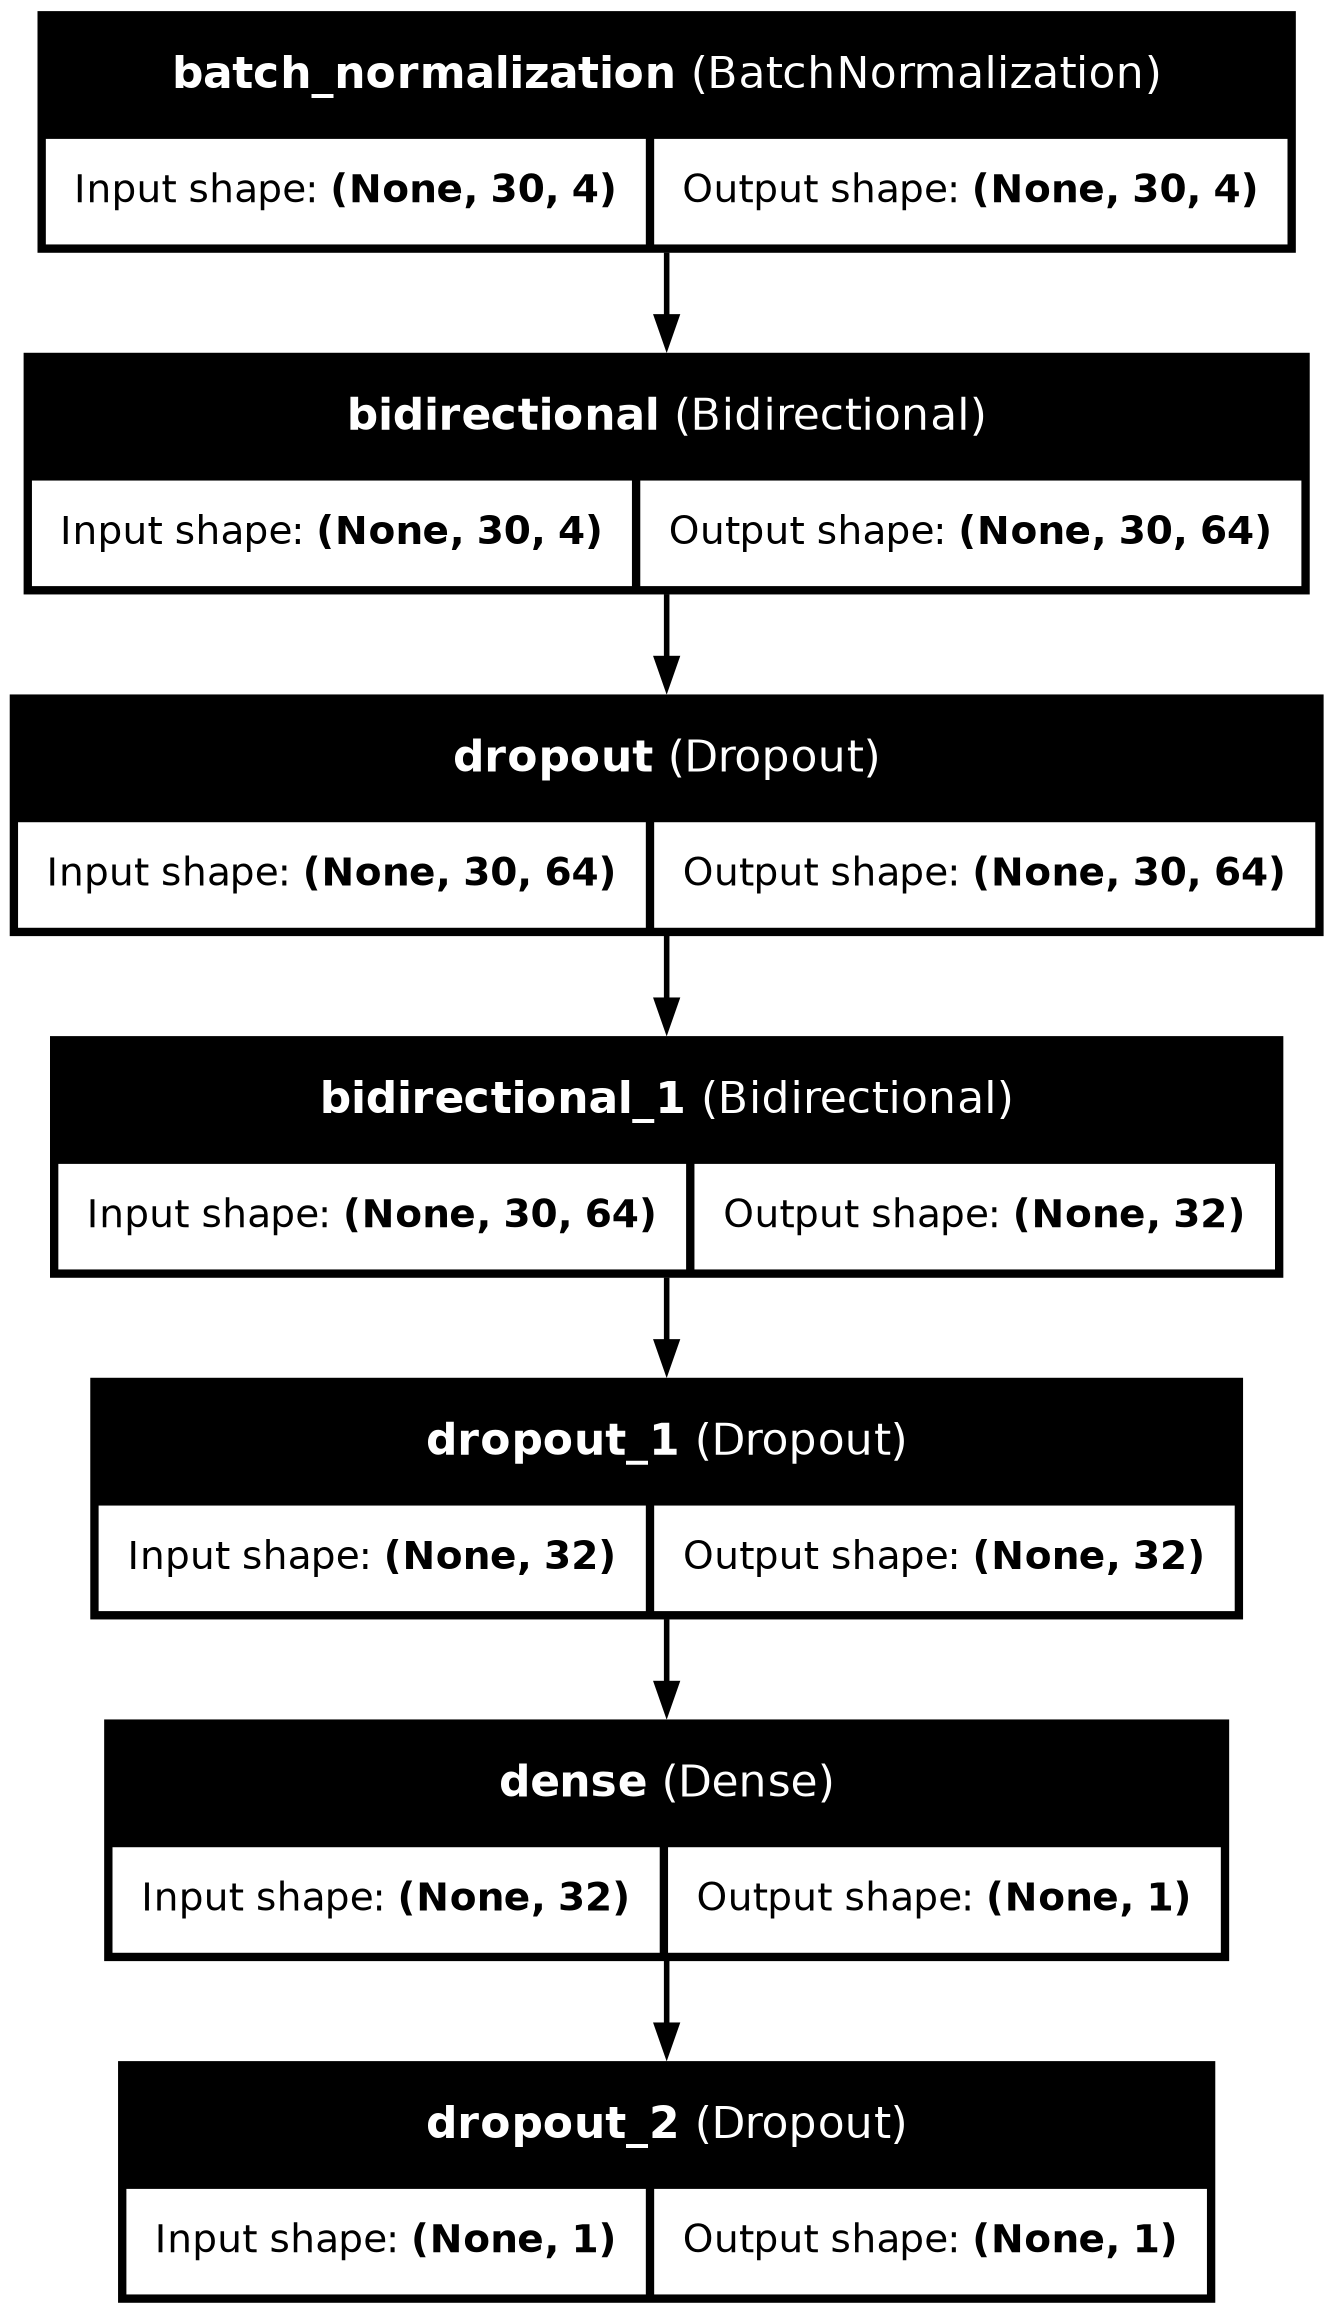

In [35]:
tf.keras.backend.clear_session()

np.random.seed(2024)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(X_val, y_val, n_past)

lstm_3 = Sequential([
  InputLayer(input_shape=(n_past, n_dims)),
  BatchNormalization(),

  Bidirectional(LSTM(32, return_sequences=True)),
  Dropout(0.1),

  Bidirectional(LSTM(16)),
  Dropout(0.1),

  Dense(1),
  Dropout(0.1),
])

lstm_3.compile(
    loss='mse',
    optimizer='adam',
    metrics=[rmspe]
)

checkpoint = ModelCheckpoint('lstm.h5.keras', save_best_only=True, monitor='val_rmspe')
early_stop = EarlyStopping(patience=30, monitor='val_rmspe', mode='min')

print(lstm_3.summary())
plot_model(lstm_3, to_file=os.path.join(directory_to_img, 'lstm_3_model.png'), show_layer_names=True, show_shapes=True)

In [36]:
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=[mat_X_val, mat_y_val], shuffle=True, 
                        verbose=0, batch_size=batch_size, epochs=200)

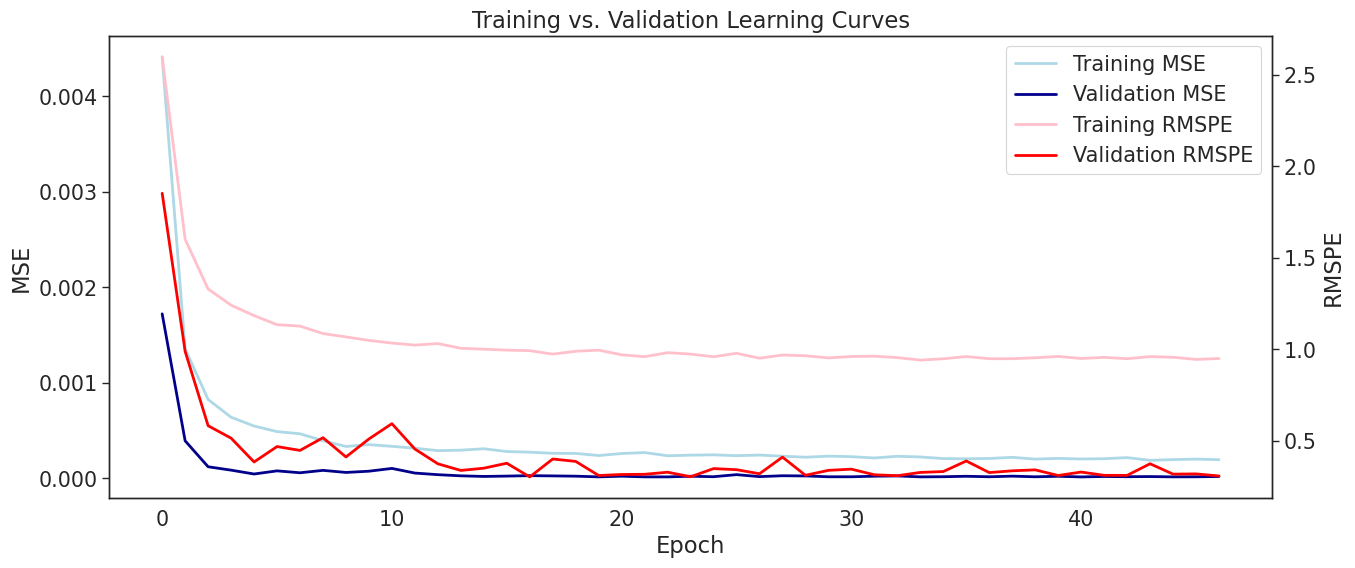

<Figure size 640x480 with 0 Axes>

In [37]:
viz_train_val_metrics(lstm_3_res)
plt.savefig(os.path.join(directory_to_img, 'error_3.png'), dpi=300, bbox_inches='tight')

In [38]:
lstm_3_preds = forecast_multi(lstm_3, val_idx)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


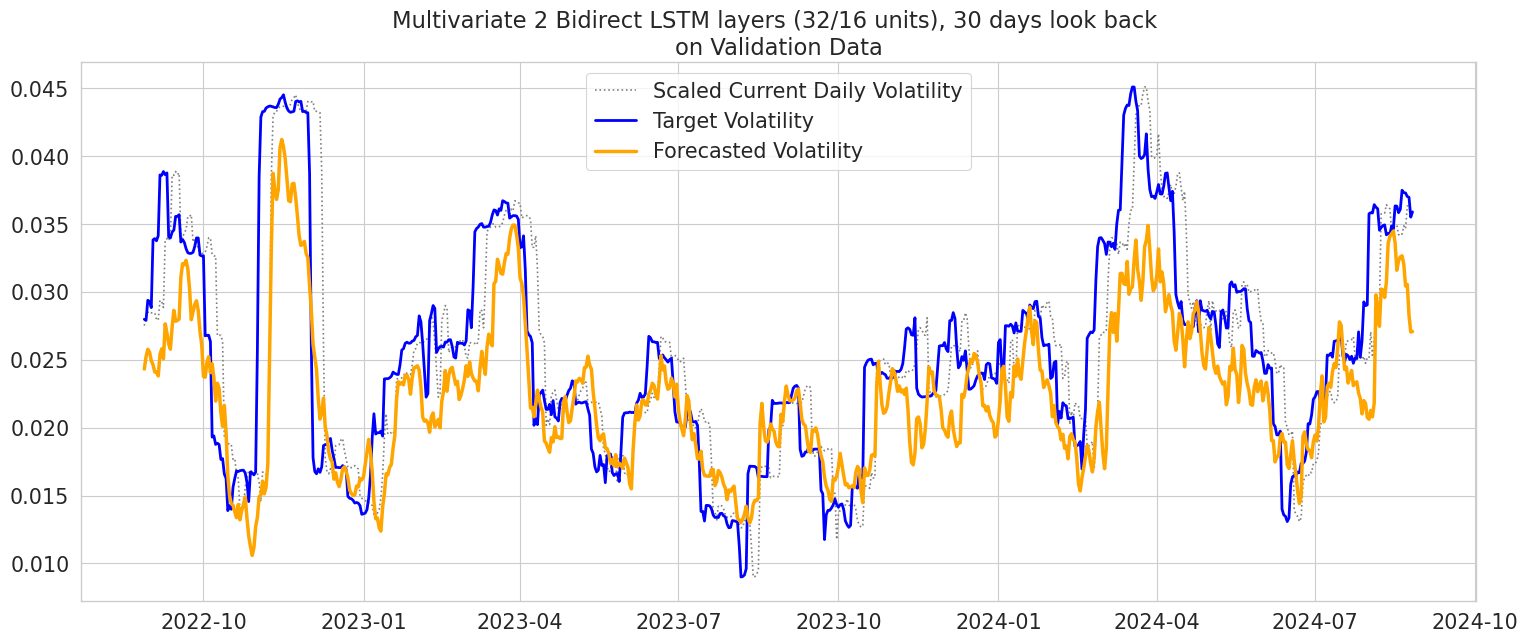

In [39]:
viz_model(y_val, lstm_3_preds, f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_3_val.png'), dpi=300, bbox_inches='tight')

In [40]:
log_perf(y_val, lstm_3_preds, f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,"LSTM 1 layer 20 units, n_past=30",0.263170,0.005638
1,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.224773,0.005690
2,Multivariate Bidirect LSTM 2 layers (32/16 uni...,0.187869,0.005548


# Basline models

### Mean Baseline

In [41]:
mean_train_vol = x_train.mean()
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=x_val.index)

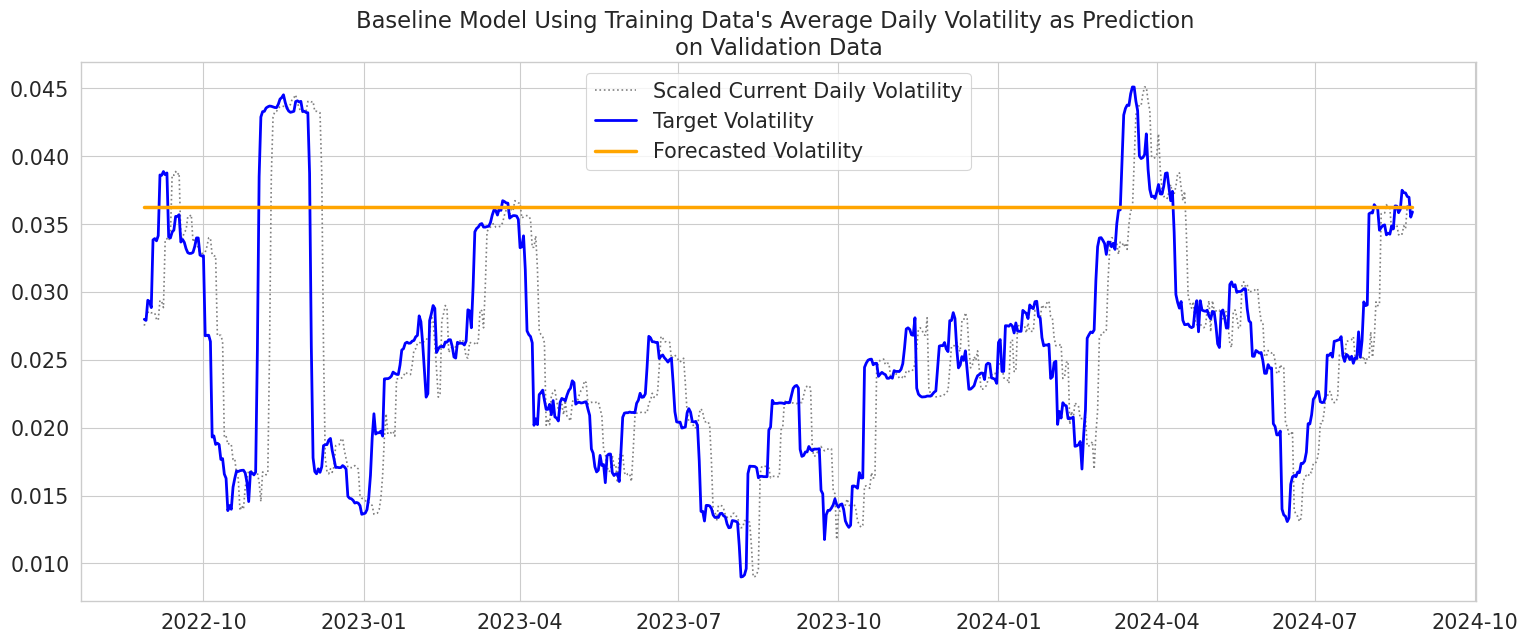

In [42]:
viz_model(y_val, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [43]:
log_perf(y_val, baseline_preds, 'Mean Baseline')

,Model,Validation RMSPE,Validation RMSE
0,"LSTM 1 layer 20 units, n_past=30",0.263170,0.005638
1,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.224773,0.005690
2,Multivariate Bidirect LSTM 2 layers (32/16 uni...,0.187869,0.005548
3,Mean Baseline,0.778559,0.013404


### Ramdom Walk Naive Forecasting

In [44]:
random_walk_preds = x_val

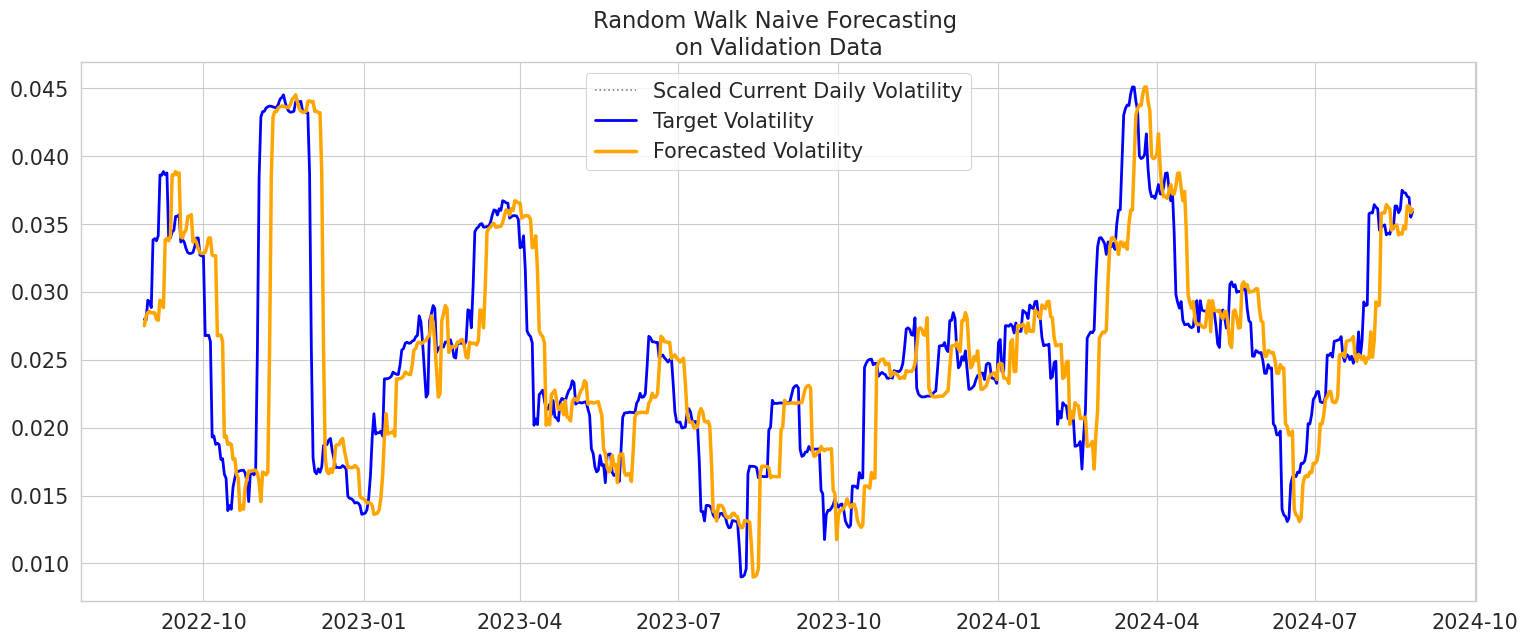

In [45]:
viz_model(y_val, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join(directory_to_img, 'naive.jpg'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [46]:
log_perf(y_val, random_walk_preds, 
         'Random Walk Naive Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,"LSTM 1 layer 20 units, n_past=30",0.263170,0.005638
1,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.224773,0.005690
2,Multivariate Bidirect LSTM 2 layers (32/16 uni...,0.187869,0.005548
3,Mean Baseline,0.778559,0.013404
4,Random Walk Naive Forecasting,0.230748,0.005177


# Evaluation

In [47]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

,Model,Validation RMSPE,Validation RMSE
2,Multivariate Bidirect LSTM 2 layers (32/16 uni...,0.187869,0.005548
1,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.224773,0.005690
4,Random Walk Naive Forecasting,0.230748,0.005177
0,"LSTM 1 layer 20 units, n_past=30",0.263170,0.005638
3,Mean Baseline,0.778559,0.013404


In [48]:
y_test_preds = forecast_multi(lstm_3, test_idx)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


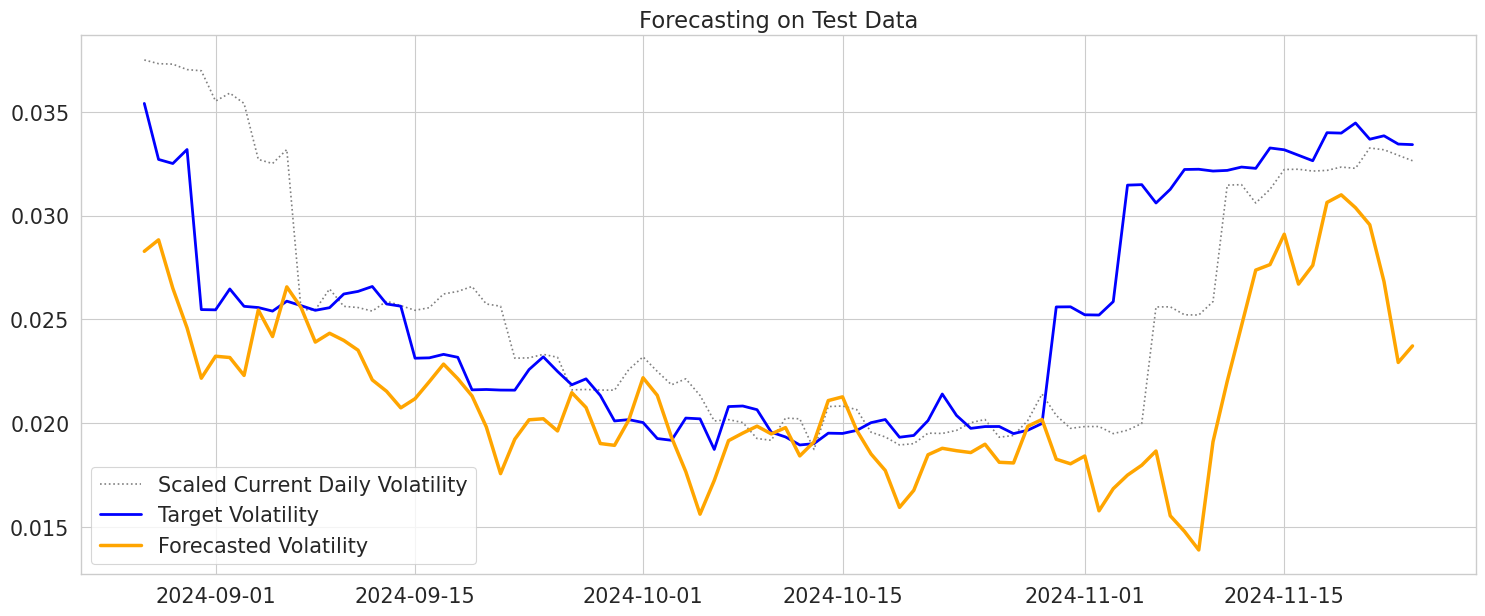

In [49]:
viz_test(y_test, y_test_preds)
plt.savefig(os.path.join(directory_to_img, 'test_evaluation.jpg'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [50]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.19246198929377595


# Prediction on whole data

In [51]:
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_3.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


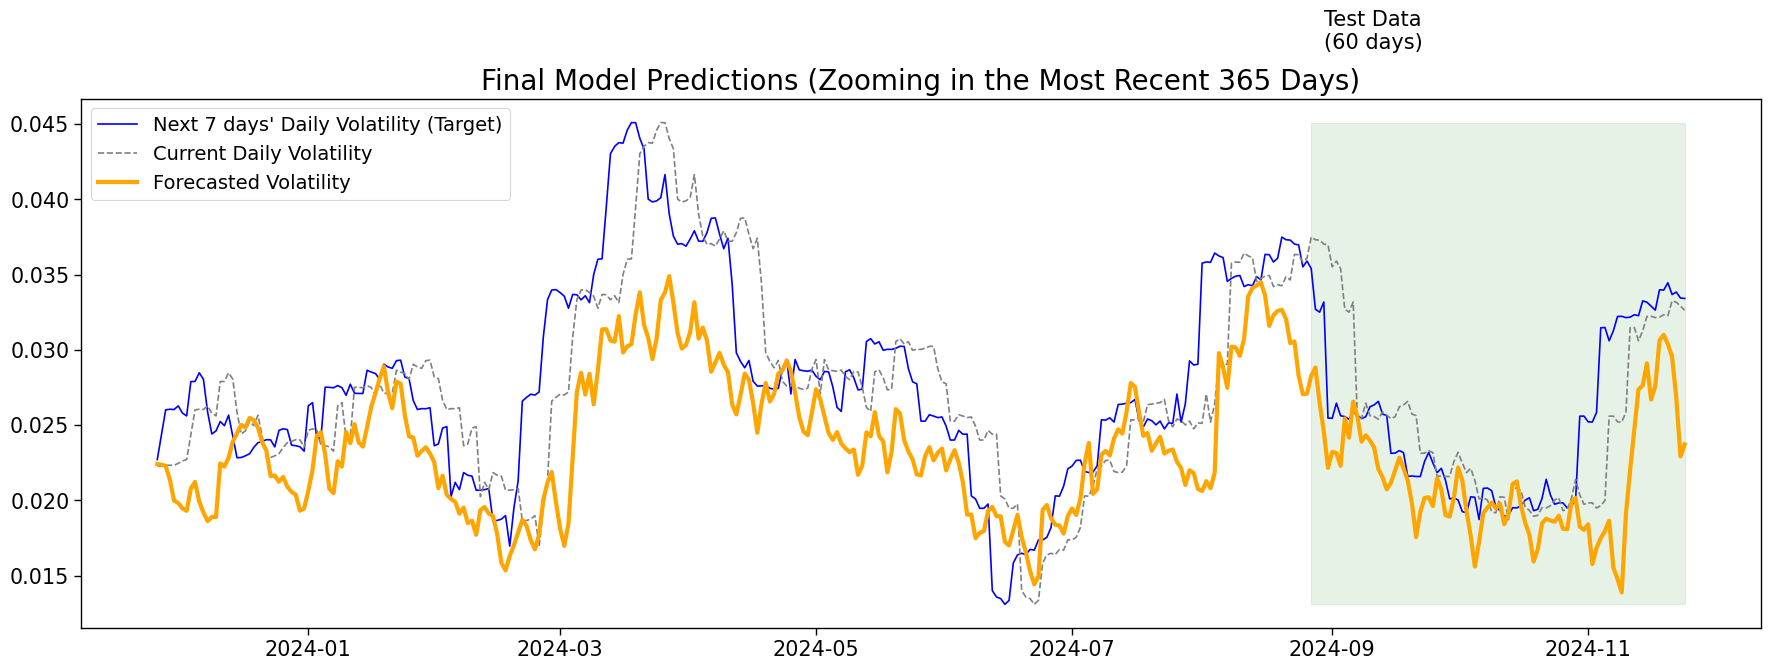

In [52]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
fig, ax1 = plt.subplots(figsize=(18,7))
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

ax1.plot(df.vol_future[-n_display:], color='blue',
            label=f"Next {n_future} days' Daily Volatility (Target)")
ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
            label=f"Current Daily Volatility")
ax1.plot(preds_all[-n_display:], color='orange', lw=3,
            label=f'Forecasted Volatility')


# ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
w = len(test_idx) - 1
h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
x0 = mdates.date2num(df.index[split_point_2])
y0 = df.vol_future[-n_display:].min()
rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
ax1.add_patch(rect)

# ADD TEXT
ax1.text(df.index[(split_point_2 + 3)], 0.05,
          'Test Data\n(60 days)',
          fontsize=15, color='black')

plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
ax1.legend(loc='upper left', prop={'size': 14})
plt.tight_layout()